In [1]:
import pandas as pd
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


from scipy.stats import pearsonr
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clip_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from config import AGD20K_PATH, model_name

from VLM_model_dot_relative import MetricsTracker
from file_managing import (
    load_selected_samples,
    get_actual_path,
    get_gt_path,
    load_ground_truth,
    prompt_dict_obj,
    get_clipseg_heatmap,
    calculate_metrics
)

def min_max_normalize(arr):
    denom = arr.max() - arr.min()
    if denom == 0:
        return np.zeros_like(arr)
    return (arr - arr.min()) / (denom + 1e-8)

metrics_tracker_alloutput = MetricsTracker(name="all_output")

AGD20K_PATH

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'/home/DATA/AGD20K'

In [3]:
metrics_tracker_alloutput = MetricsTracker(name="all_output")
# 저장할 디렉토리 생성
output_dir = "./output_last_token_baseline"
os.makedirs(output_dir, exist_ok=True)
    
for i in range(24):
    i += 1
    df_output = pd.read_pickle(f"output_results/attention_result_full_output_32B_{i}.pkl")


    for idx, row in df_output.iterrows():
        # 1. 빈 히트맵 초기화 (31x31)
        sum_heatmap = np.zeros((31, 31), dtype=np.float32)

        object_name = row['object']
        action = row['action']
        filename = row['filename']
        output_description = row['output_sentence']
        output_attentions = row['output_attentions']
        
        file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
        gt_path = f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
            
        orig_img = cv2.imread(file_name_real)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        h, w, _ = orig_img.shape

        print(f"[{idx}] Processing: {action} - {object_name}")

        # # --- CLIPSeg Mask 생성 ---
        # clip_heatmap = get_clipseg_heatmap(
        #     file_name_real,
        #     clip_model,
        #     processor,
        #     object_name,
        # )
        # # CLIPSeg 결과를 31x31로 리사이즈 (평균 히트맵과 연산을 위해 크기 일치 필요)
        # clip_heatmap_resized = cv2.resize(clip_heatmap, (31, 31), interpolation=cv2.INTER_LINEAR)
        # clip_binary_mask = (clip_heatmap_resized > 0.15).astype(np.float32)

        # 2. 모든 어텐션 히트맵 합산
        total_heads_count = 0
        token = output_attentions[-1]

        attention_value = token['attentions']
        for each_attention in attention_value:
            layer = each_attention['layer']
            head = each_attention['head']
            
            if  1==1: #(layer == 26) and( head ==20) or ((layer == 24) and( head ==31)):
                
                sum_heatmap += each_attention['heatmap']
                total_heads_count += 1
            
        # # 3. 평균 및 정규화
        average_heatmap = sum_heatmap / (total_heads_count + 1e-8)
        h_min, h_max = average_heatmap.min(), average_heatmap.max()
        avg_norm = (average_heatmap - h_min) / (h_max - h_min + 1e-8)

        # CLIPSeg와 Hadamard Product
        # avg_norm_cliped = avg_norm * clip_heatmap_resized
        avg_norm_cliped = avg_norm
        gamma = 0.75  # 0
        avg_norm_cliped = np.power(avg_norm_cliped, gamma)
        # 리사이즈 및 블러링
        avg_norm_cliped_rescaled = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)



        avg_norm_cliped_rescaled = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)
        # 2. 커널 사이즈 결정 (이미지 크기의 약 5~10% 추천)
        sig = min(w, h) * 0.05 
        k_val = int(sig * 3) * 2 + 1 # 시그마에 따른 적절한 홀수 커널 사이즈 계산
        kernel_size = (k_val, k_val)

        # 3. 블러 적용 (float32 상태에서 수행)
        blur_map = cv2.GaussianBlur(avg_norm_cliped_rescaled, kernel_size, sig)

        # 4. 블러 후 다시 정규화 (값이 낮아질 수 있으므로)
        blur_map = min_max_normalize(blur_map)

        # 5. 시각화 방식 선택 (택 1)
        # 방법 A: matplotlib의 cmap 사용 (추천: 코드가 깔끔함)
        avg_norm_cliped_blur = blur_map

        ## resize
        avg_norm_cliped = cv2.resize(avg_norm_cliped, (w, h), interpolation=cv2.INTER_LINEAR)

        # 4. 시각화 (서브플롯 5개)
        fig, axes = plt.subplots(1, 6, figsize=(22, 6)) # 가로로 길게 설정
        

        ## GT metrics
        gt_map = load_ground_truth(gt_path)
        if gt_map is not None:
            metrics_dino  = calculate_metrics(avg_norm_cliped_blur, gt_map)
            metrics_tracker_alloutput.update(metrics_dino)
        else:
            print("NO GT!!!")
            continue
        metrics_tracker_alloutput.print_metrics(metrics_dino, filename)
        metrics_text = f"[{object_name} {action} {filename}]  KLD: {metrics_dino['KLD']:.4f} | SIM: {metrics_dino['SIM']:.4f} | NSS: {metrics_dino['NSS']:.4f}"
    


        # --- [핵심 추가] 전체 제목 설정 ---
        # object_name / action / filename 표시
        main_title = f"Object: {object_name}  |  Action: {action}  |  File: {filename} \n {metrics_text} \n {output_description}"

        fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.95)

        # (1) 원본 이미지
        img_real = cv2.imread(file_name_real)
        img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_real)
        axes[0].set_title(f"Original\n({object_name})")
        axes[0].axis('off')

        # (2) 전체 평균 Attention
        im1 = axes[1].imshow(avg_norm, cmap='jet', interpolation='bilinear')
        axes[1].set_title("Avg Attention")
        axes[1].axis('off')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        # (3) CLIPSeg Binary Mask (0 or 1)
        axes[2].imshow(clip_heatmap_resized, cmap='gray')
        axes[2].set_title("clip_heatmap_resized")
        axes[2].axis('off')

        # (4) Masked Attention (Attention x Mask)
        im3 = axes[3].imshow(avg_norm_cliped, cmap='jet', interpolation='bilinear')
        axes[3].set_title("Hadamard\nAttention")
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)


        # (4) Masked Attention (Attention x Mask)
        im3 = axes[4].imshow(avg_norm_cliped_blur, cmap='jet', interpolation='bilinear')
        axes[4].set_title("Blured")
        axes[4].axis('off')
        plt.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)



        img_gt = cv2.imread(gt_path)
        img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
        axes[5].imshow(img_gt)
        axes[5].set_title("Ground Truth")

        axes[5].axis('off')

        # 5. 파일 저장
        save_path = os.path.join(output_dir, f"{object_name}_{action}_{filename.split('.')[0]}.png")
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        plt.close(fig)


[0] Processing: cut - apple

Metrics for all_output apple_000054.jpg:
 all_output Current - KLD: 1.6810 | SIM: 0.2668 | NSS: -0.3636

Cumulative all_output  Averages over 1 samples:
Average - KLD: 1.6810 | SIM: 0.2668 | NSS: -0.3636

[1] Processing: eat - apple

Metrics for all_output apple_001541.jpg:
 all_output Current - KLD: 2.3832 | SIM: 0.1362 | NSS: -0.3350

Cumulative all_output  Averages over 2 samples:
Average - KLD: 2.0321 | SIM: 0.2015 | NSS: -0.3493

[2] Processing: peel - apple

Metrics for all_output apple_001541.jpg:
 all_output Current - KLD: 2.6230 | SIM: 0.1196 | NSS: -0.3530

Cumulative all_output  Averages over 3 samples:
Average - KLD: 2.2291 | SIM: 0.1742 | NSS: -0.3505

[3] Processing: hit - axe

Metrics for all_output axe_000961.jpg:
 all_output Current - KLD: 2.4821 | SIM: 0.1406 | NSS: -0.2593

Cumulative all_output  Averages over 4 samples:
Average - KLD: 2.2923 | SIM: 0.1658 | NSS: -0.3277

[4] Processing: hold - axe

Metrics for all_output axe_001552.jpg:


In [5]:
gamma

0.75

In [ ]:
output last token :   KLD: 1.2934 | SIM: 0.3905 | NSS: 0.9825  // KLD: 1.1882 | SIM: 0.4344 | NSS: 1.0598


In [1]:
import numpy as np

In [4]:
np.power(0.1,0.75)

np.float64(0.1778279410038923)

In [3]:
np.power(2,0.75)

np.float64(1.681792830507429)

In [ ]:

# 저장할 디렉토리 생성
output_dir = "./output_average"
os.makedirs(output_dir, exist_ok=True)

for idx, row in df_output.iterrows():
    # 1. 빈 히트맵 초기화 (31x31)
    sum_heatmap = np.zeros((31, 31), dtype=np.float32)

    object_name = row['object']
    action = row['action']
    filename = row['filename']
    output_attentions = row['output_attentions']
    
    file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
    gt_path = f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
    
    print(f"[{idx}] Processing: {action} - {object_name}")

    # --- CLIPSeg Mask 생성 ---
    clip_heatmap = get_clipseg_heatmap(
        file_name_real,
        clip_model,
        processor,
        object_name,
    )
    # CLIPSeg 결과를 31x31로 리사이즈 (평균 히트맵과 연산을 위해 크기 일치 필요)
    clip_heatmap_resized = cv2.resize(clip_heatmap, (31, 31), interpolation=cv2.INTER_LINEAR)
    clip_binary_mask = (clip_heatmap_resized > 0.15).astype(np.float32)

    # 2. 모든 어텐션 히트맵 합산
    total_heads_count = 0
    for token in output_attentions:
        attention_value = token['attentions']
        for each_attention in attention_value:
            sum_heatmap += each_attention['heatmap']
            total_heads_count += 1
        
    # 3. 평균 및 정규화
    average_heatmap = sum_heatmap / (total_heads_count + 1e-8)
    h_min, h_max = average_heatmap.min(), average_heatmap.max()
    avg_norm = (average_heatmap - h_min) / (h_max - h_min + 1e-8)

    # 마스킹 적용 (Attention * Mask)
    avg_norm_masked = avg_norm * clip_binary_mask

    # 4. 시각화 (서브플롯 5개)
    fig, axes = plt.subplots(1, 5, figsize=(22, 6)) # 가로로 길게 설정
    
    # --- [핵심 추가] 전체 제목 설정 ---
    # object_name / action / filename 표시
    main_title = f"Object: {object_name}  |  Action: {action}  |  File: {filename}"
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.95)

    # (1) 원본 이미지
    img_real = cv2.imread(file_name_real)
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_real)
    axes[0].set_title(f"Original\n({object_name})")
    axes[0].axis('off')

    # (2) 전체 평균 Attention
    im1 = axes[1].imshow(avg_norm, cmap='jet', interpolation='bilinear')
    axes[1].set_title("Avg Attention")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # (3) CLIPSeg Binary Mask (0 or 1)
    axes[2].imshow(clip_binary_mask, cmap='gray')
    axes[2].set_title("CLIPSeg Mask\n(Threshold 0.15)")
    axes[2].axis('off')

    # (4) Masked Attention (Attention x Mask)
    im3 = axes[3].imshow(avg_norm_masked, cmap='jet', interpolation='bilinear')
    axes[3].set_title("Masked\nAttention")
    axes[3].axis('off')
    plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

    # (5) Ground Truth
    if os.path.exists(gt_path):
        img_gt = cv2.imread(gt_path)
        img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
        axes[4].imshow(img_gt)
        axes[4].set_title("Ground Truth")
    else:
        axes[4].text(0.5, 0.5, "GT Not Found", ha='center')
    axes[4].axis('off')

    # 5. 파일 저장
    save_path = os.path.join(output_dir, f"{object_name}_{action}_{filename.split('.')[0]}.png")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)



[0] Processing: cut - apple
[1] Processing: eat - apple
[2] Processing: peel - apple
[3] Processing: hit - axe
[4] Processing: hold - axe
완료! 저장 위치: ./output_average


In [ ]:
for idx, row in df_output.iterrows():

    # 1. 빈 히트맵 초기화 (31x31)
    sum_heatmap = np.zeros((31, 31), dtype=np.float32)

    object_name = row['object']
    action = row['action']
    filename = row['filename']
    llm_output = row['output_sentence']
    output_attentions = row['output_attentions']
    file_name_real = f"{AGD20K_PATH}/Seen/testset/egocentric/{action}/{object_name}/{filename}"
    gt_path =  f"{AGD20K_PATH}/Seen/testset/GT/{action}/{object_name}/{filename.split('.')[0]}.png"
    print(f"Processing image {idx}, object : {object_name}, action : {action} // Total tokens for output sentence : {len(output_attentions)}")
    

    clip_heatmap = get_clipseg_heatmap(
    file_name_real,
    clip_model, # Pass the model object (now on GPU)
    processor,
    object_name,
    )
    # 2. CLIPSeg 히트맵을 0,1의 바이너리마스크로 만듬
    clip_binary_mask = (clip_heatmap > 0.15).astype(np.float32)


    for token_idx, token in enumerate(output_attentions):
        attention_value = token['attentions']
        for each_attention in attention_value:
            each_layer = each_attention['layer']
            each_head = each_attention['head']
            # print(f"Layer : {each_layer}, Head : {each_head}, heatmap size : {np.shape(each_attention['heatmap'])}")
            each_heatmap = each_attention['heatmap']
            sum_heatmap += each_heatmap
        
    # 3. 평균 히트맵 계산 (선택 사항: 정규화를 하면 결과는 동일함)
    average_heatmap = sum_heatmap / len(attention_value)

    # 4. Min-Max Normalization (0 ~ 1 사이로 맞춤)
    heatmap_min = average_heatmap.min()
    heatmap_max = average_heatmap.max()

    # 분모가 0이 되는 것을 방지하기 위해 아주 작은 값(1e-8)을 더해줄 수 있습니다.
    average_heatmap_normalized = (average_heatmap - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)

Processing image 0, object : apple, action : cut // Total tokens for output sentence : 33


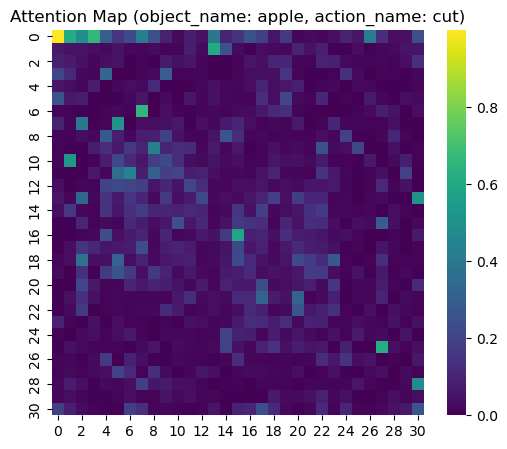

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# inside_heatmap이 (31, 31)이라고 가정
plt.figure(figsize=(6, 5))
sns.heatmap(average_heatmap_normalized, cmap='viridis') # 또는 'jet', 'hot' 등 선호하는 컬러맵 사용
plt.title(f"Attention Map (object_name: {object_name}, action_name: {action})")
plt.show()